In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
c1 = pd.read_csv('IPQDA_23_ASS_D_DATA/tracked_Akt_KTR.csv', index_col='LABEL')
c2 = pd.read_csv('IPQDA_23_ASS_D_DATA/tracked_ERK_KTR.csv', index_col='LABEL')

In [4]:
c1 = c1.iloc[3:]
c2 = c2.iloc[3:]

In [5]:
c1.columns

Index(['ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y', 'POSITION_Z',
       'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY', 'MANUAL_SPOT_COLOR',
       'MEAN_INTENSITY_CH1', 'MEDIAN_INTENSITY_CH1', 'MIN_INTENSITY_CH1',
       'MAX_INTENSITY_CH1', 'TOTAL_INTENSITY_CH1', 'STD_INTENSITY_CH1',
       'CONTRAST_CH1', 'SNR_CH1'],
      dtype='object')

### Print the incomplete tracks

In [6]:
frame_counts = c1.groupby('TRACK_ID')['FRAME'].nunique()
incomplete_tracks = frame_counts[frame_counts < 27]
print(incomplete_tracks)

TRACK_ID
1000    8
1001    9
1002    7
1003    8
1004    8
       ..
995     6
996     7
997     8
998     9
999     7
Name: FRAME, Length: 327, dtype: int64


## Processing time-series data

### Bootstrap

In [7]:
df_bootstrap1 = c1.sample(n=len(c1), replace=True)
df_bootstrap2 = c2.sample(n=len(c1), replace=True)

### Calculate the median intensity

In [8]:
df_median1 = df_bootstrap1.groupby(['TRACK_ID', 'FRAME'])['MEDIAN_INTENSITY_CH1'].median().reset_index()
df_median2 = df_bootstrap2.groupby(['TRACK_ID', 'FRAME'])['MEDIAN_INTENSITY_CH1'].median().reset_index()

### Calculate the steady state intensity for the first 6 frame and normalize the intensity

In [9]:
df_median1['FRAME'] = df_median1['FRAME'].astype(int)
df_median1['steady_state_intensity'] = df_median1[df_median1['FRAME'] <= 6]['MEDIAN_INTENSITY_CH1'].median()
df_median1['normalized_intensity'] = df_median1['MEDIAN_INTENSITY_CH1'] / df_median1['steady_state_intensity']

df_median2['FRAME'] = df_median2['FRAME'].astype(int)
df_median2['steady_state_intensity'] = df_median2[df_median2['FRAME'] <= 6]['MEDIAN_INTENSITY_CH1'].median()
df_median2['normalized_intensity'] = df_median2['MEDIAN_INTENSITY_CH1'] / df_median2['steady_state_intensity']

### Calculate the global median intensity

In [10]:
df_global_median1 = df_median1.groupby('TRACK_ID')['normalized_intensity'].median().reset_index()
df_global_median2 = df_median2.groupby('TRACK_ID')['normalized_intensity'].median().reset_index()

## Calculate the maximal outflow and the corresponding rates

In [11]:
df_median1['FRAME'] = df_median1['FRAME'].astype(int)
df_median2['FRAME'] = df_median2['FRAME'].astype(int)

### Calculate global steady state intensity

In [12]:
global_steady_state_intensity1 = df_median1[df_median1['FRAME'] <= 6]['normalized_intensity'].median()
global_steady_state_intensity2 = df_median2[df_median2['FRAME'] <= 6]['normalized_intensity'].median()

### Calculate the minimal intensity

In [13]:
df_minimal1 = df_median1[df_median1['FRAME'] >= 7].groupby('TRACK_ID')['normalized_intensity'].min().reset_index()
df_minimal1.rename(columns={'normalized_intensity': 'minimal_intensity'}, inplace=True)

df_minimal2 = df_median2[df_median2['FRAME'] >= 7].groupby('TRACK_ID')['normalized_intensity'].min().reset_index()
df_minimal2.rename(columns={'normalized_intensity': 'minimal_intensity'}, inplace=True)

### Calculate the maximal change for each kinase

In [14]:
df_minimal1['maximal_change'] = (global_steady_state_intensity1 - df_minimal1['minimal_intensity']) / global_steady_state_intensity1
df_minimal2['maximal_change'] = (global_steady_state_intensity2 - df_minimal2['minimal_intensity']) / global_steady_state_intensity2

In [15]:
df_global_median1 = df_global_median1.merge(df_minimal1, on='TRACK_ID')
df_global_median2 = df_global_median2.merge(df_minimal2, on='TRACK_ID')

In [16]:
df_global_median1['minimal_intensity_frame'] = np.nan
df_global_median2['minimal_intensity_frame'] = np.nan

### For each track in the global median, get the frame where the minimal intensity occurred and assign it to a new column 'minimal_intensity_frame'

In [17]:
for i in df_global_median1.index:
    track_id = df_global_median1.loc[i, 'TRACK_ID']
    minimal_intensity = df_global_median1.loc[i, 'minimal_intensity']
    minimal_intensity_frame = df_median1[(df_median1['TRACK_ID'] == track_id) & (df_median1['normalized_intensity'] == minimal_intensity)]['FRAME'].values[0]
    df_global_median1.loc[i, 'minimal_intensity_frame'] = minimal_intensity_frame

for i in df_global_median2.index:
    track_id = df_global_median2.loc[i, 'TRACK_ID']
    minimal_intensity = df_global_median2.loc[i, 'minimal_intensity']
    minimal_intensity_frame = df_median2[(df_median2['TRACK_ID'] == track_id) & (df_median2['normalized_intensity'] == minimal_intensity)]['FRAME'].values[0]
    df_global_median2.loc[i, 'minimal_intensity_frame'] = minimal_intensity_frame

In [18]:
# Calculate the duration in minutes
df_global_median1['duration'] = df_global_median1['minimal_intensity_frame'] - 7
df_global_median2['duration'] = df_global_median2['minimal_intensity_frame'] - 7

### Calculate the rate of maximal change

In [19]:
df_global_median1['rate_of_change'] = df_global_median1['maximal_change'] / df_global_median1['duration']
df_global_median2['rate_of_change'] = df_global_median2['maximal_change'] / df_global_median2['duration']

In [20]:
df_global_median1['KINASE'] = 'Akt'
df_global_median2['KINASE'] = 'ERK'
df_global_median = pd.concat([df_global_median1, df_global_median2])

In [21]:
overall_maximal_change = df_global_median.groupby(['KINASE', 'minimal_intensity_frame'])['maximal_change'].median().reset_index()
overall_rate_of_change = df_global_median.groupby(['KINASE', 'minimal_intensity_frame'])['rate_of_change'].median().reset_index()

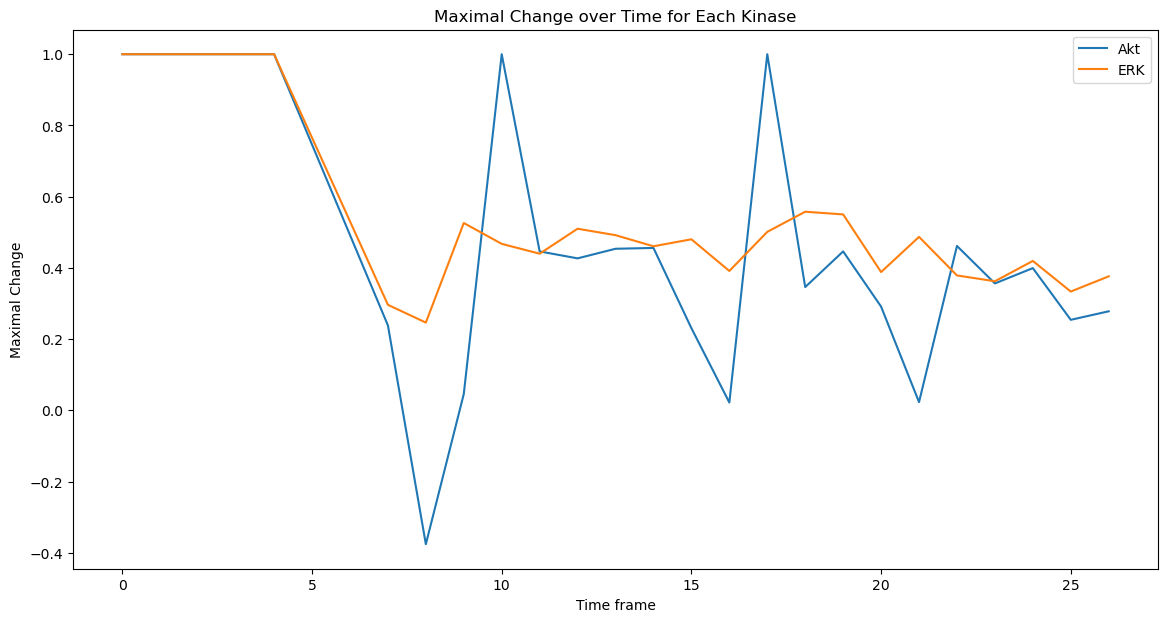

In [22]:
plt.figure(figsize=(14, 7))
for kinase in overall_maximal_change['KINASE'].unique():
    plt.plot(overall_maximal_change[overall_maximal_change['KINASE'] == kinase]['minimal_intensity_frame'],
             overall_maximal_change[overall_maximal_change['KINASE'] == kinase]['maximal_change'], label=kinase)
plt.xlabel('Time frame')
plt.ylabel('Maximal Change')
plt.legend()
plt.title('Maximal Change over Time for Each Kinase')
plt.show()

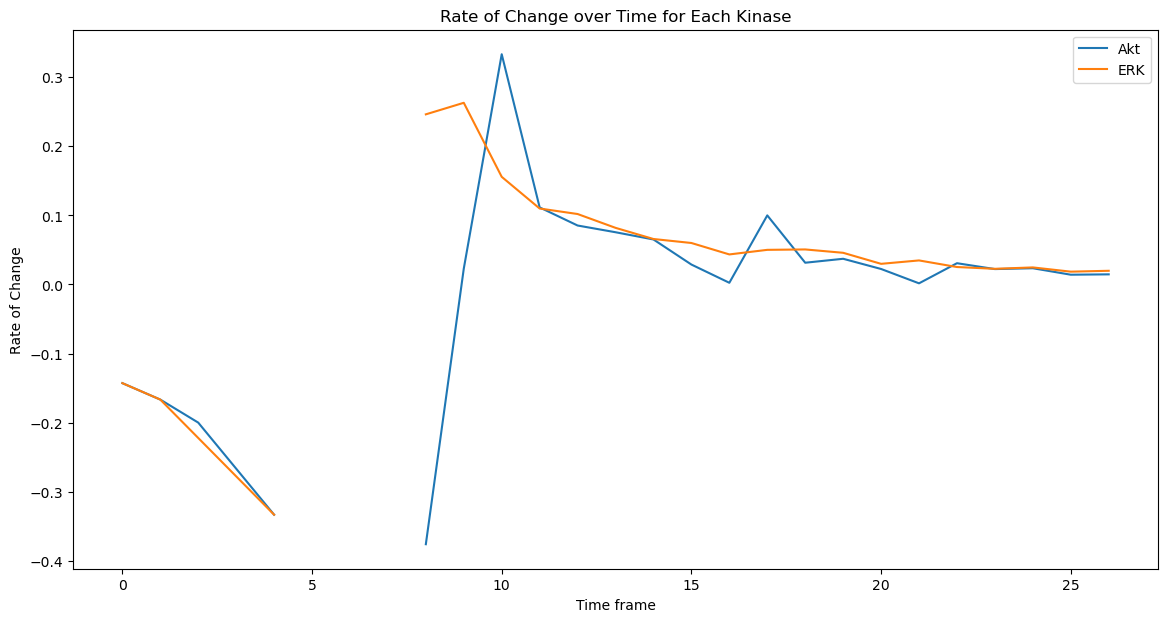

In [23]:
plt.figure(figsize=(14, 7))
for kinase in overall_rate_of_change['KINASE'].unique():
    plt.plot(overall_rate_of_change[overall_rate_of_change['KINASE'] == kinase]['minimal_intensity_frame'],
             overall_rate_of_change[overall_rate_of_change['KINASE'] == kinase]['rate_of_change'], label=kinase)
plt.xlabel('Time frame')
plt.ylabel('Rate of Change')
plt.legend()
plt.title('Rate of Change over Time for Each Kinase')
plt.show()

In [24]:
median_rate_of_change_Akt = df_global_median1['rate_of_change'].median()
median_rate_of_change_ERK = df_global_median2['rate_of_change'].median()

median_maximal_change_Akt = df_global_median1['maximal_change'].median()
median_maximal_change_ERK = df_global_median2['maximal_change'].median()

print(f"Median rate of change for Akt: {median_rate_of_change_Akt}")
print(f"Median rate of change for ERK: {median_rate_of_change_ERK}")
print(f"Median maximal change for Akt: {median_maximal_change_Akt}")
print(f"Median maximal change for ERK: {median_maximal_change_ERK}")

Median rate of change for Akt: 0.020520846919699146
Median rate of change for ERK: 0.07093490826840915
Median maximal change for Akt: 0.36236933797909404
Median maximal change for ERK: 0.486303091228952
